# Deleting previous folders ```dataset``` and ```runs```

In [1]:
!rmdir /s data /q
print("Folder 'data' has deleted")
!rmdir /s datasets /q
print("Folder 'datasets' has deleted")
!rmdir /s runs /q
print("Folder 'runs' has deleted")

Folder 'data' has deleted
Folder 'datasets' has deleted
Folder 'runs' has deleted


The system cannot find the file specified.


# Preparing data

### Unzip zip with data from Label Studio

In [2]:
# !unzip raw_data.zip -d /content/raw_data

## Create path variables and create folder for dataset

In [1]:
import os

# Define constant variables
HOME = os.getcwd()
RAW_DATA_PATH = os.path.join(HOME, 'raw_data') # data from label studio
DATA_PATH = os.path.join(HOME, 'data') # augmented data
DATASET_PATH = os.path.join(HOME, 'datasets') # dataset prepared for training

# Make folder for DATA_PATH
os.makedirs(DATA_PATH, exist_ok=True)
# Make folder for DATASET_PATH
os.makedirs(DATASET_PATH, exist_ok=True)
    
print(f"\nHOME directory is {HOME}")
print(f"Folder with labelled images is {RAW_DATA_PATH}")
print(f"Folder with augmented images is {DATA_PATH}")
print(f"Folder with prepared dataset is {DATASET_PATH}")


HOME directory is C:\D\Python\portfolio\Projects\pills-segmentation
Folder with labelled images is C:\D\Python\portfolio\Projects\pills-segmentation\raw_data
Folder with augmented images is C:\D\Python\portfolio\Projects\pills-segmentation\data
Folder with prepared dataset is C:\D\Python\portfolio\Projects\pills-segmentation\datasets


## Augmenting data

### Helping functions

In [24]:
import os
import shutil
import random
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug import Polygon, Keypoint
from PIL import Image
import imageio
import cv2
from skimage.transform import resize

from tqdm.auto import tqdm
import time


def create_dict_with_images_and_labels(data_path, shuffle=False):
    '''
    Takes data path and creates dict with names of images
    with corresponding names of labels
    '''
    # Define images path and labels path
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')
    
    # Get the list of images and labels
    images = os.listdir(images_path)
    labels = os.listdir(labels_path)

    # Create a dictionary to store the images and labels names
    images_and_labels = {}
    
    for image in images:
        label = image.rstrip('.jpg') + '.txt'

        if label in labels:
            images_and_labels[image] = label
            
    if shuffle:
        # Shuffle the data
        keys = list(images_and_labels.keys())
        random.shuffle(keys)
        images_and_labels = {key: images_and_labels[key] for key in keys}
            
    return images_and_labels


def parse_labels_file(file_path):
    '''
    Gets txt file of labels and returns list with dicts, 
    that contains label and polygon points
    '''
    with open(file_path, 'r') as f:
        lines = f.readlines()
    labels = []
    for line in lines:
        line = line.strip().split()
        label_class = int(line[0])
        polygon = []
        for i in range(1, len(line), 2):
            x = float(line[i])
            y = float(line[i+1])
            polygon.append((x, y))
        labels.append({'class': label_class, 'polygon': polygon})
    
    # Find counts of each class
    class_counts = {}

    for one_dict in labels:
        class_counts[one_dict['class']] = class_counts.get(one_dict['class'], 0) + 1
    
    return labels, class_counts

def extract_and_convert_polygons(points_with_labels, image_width, image_height):
    '''
    Extracts polygons from points_with_labels dict and convert it 
    from yolo(standartized) format to format with width and height
    and returns original_polygons for one image
    '''
    # Convert points to a Polygon objects
    # Create list for storing polygons for one image
    original_polygons = []
    # Iterating through list of dicts with points and labels
    for polygon_dict in points_with_labels:
        # Convert points to a Keypoint objects
        # Create a list for storing keypoints
        keypoints = []
        
        # Iterating through points
        for point_x, point_y in polygon_dict['polygon']:

            # Value translation
            translated_point_x = point_x*image_width
            translated_point_y = point_y*image_height

            # Labels of each polygon
            label = polygon_dict['class']
            
            # Convert points to a Keypoint object
            keypoint = Keypoint(translated_point_x, translated_point_y)
            
            # Appending keypoint to list with keypoints objects
            keypoints.append(keypoint)

        # Convert keypoints to a Polygon objects  
        polygon = Polygon(keypoints, label=polygon_dict['class'])
        # Appending polygon to list with polygons objects 
        original_polygons.append(polygon)
        
        # # Create list comprehension for storing polygons (another way)
        # original_polygons = [Polygon([Keypoint(point_x*image_width, point_y*image_height) \
        #                     for point_x, point_y in polygon_dict['polygon']], label=polygon_dict['class']) /
        #                     for polygon_dict in points_with_labels]
        
    return original_polygons


def visualize_augmentation(image_array, original_polygons, images_aug,  polygons_aug):
    '''
    Takes one image and num of augmented factor augmented images and saves result as grid image
    '''
    # Creating list for containing images
    cells = []
    
    # Create counter for counting
    counter = 0
    
    print('Visualizing augmentation has started.')
    
    # Iterating through augmented images and polygons
    for image_aug, polygon_aug in zip(images_aug, polygons_aug):
        # Append original image to cells
        cells.append(image_array)

        # Append labelled original image to cells
        labelled_image = np.copy(image_array)
        # Iterating through all polygons
        for pols in original_polygons:
            labelled_image = pols.draw_on_image(labelled_image)
        cells.append(labelled_image)

        # Append augmented image to cells
        cells.append(image_aug)

        # Append labelled augmented image to cells
        labelled_augmented_image = np.copy(image_aug)
        
        # Iterating through all polygons
        for pols in polygon_aug:
            labelled_augmented_image = pols.draw_on_image(labelled_augmented_image)
        cells.append(labelled_augmented_image)

        # Counting
        counter += 1
        print(f"Visualization stage {str(counter)} of {str(len(images_aug))} has completed")

    # Convert cells to a grid image and save.
    grid_image = ia.draw_grid(cells, cols=4)
    imageio.imwrite("example_polygons.jpg", grid_image)
    
    
def save_polygons_to_txt(polygons, image_width, image_height, filepath):
    '''
    Saves list of polygons to txt file in yolov8 format
    '''
    with open(filepath, 'w') as f:
        # Iterating through each polygon
        for polygon in polygons:
            # Write label of 1 polygon
            f.write(f"{polygon.label} ")
            
            # Iterating through each point
            for point in polygon.exterior:
                x, y = point[0], point[1]
                x = x / image_width
                y = y / image_height
                # Check if label is not out of coordinates
                if (x < 0 or x > 1) or (y < 0 or y > 1):
                    continue
                # Write each coordinate
                f.write(f"{x} {y} ")
            f.write('\n')
        
    return None
    

def resize_images(images, output_shape):
    """
    Resizes an array of images to the same shape while maintaining aspect ratio.
    
    Args:
    images (numpy.ndarray): An array of images with different shapes.
    output_shape (tuple): A tuple of integers specifying the desired output shape, in the format (height, width).
    
    Returns:
    numpy.ndarray: An array of resized images with the same shape.
    """
    resized_images = np.zeros((len(images), output_shape[0], output_shape[1], images[0].shape[2]), dtype=images[0].dtype)
    
    for i, image in enumerate(images):
        # Resize the image using the `resize` function from the `skimage.transform` module
        resized_image = resize(image, output_shape, mode='reflect', preserve_range=True, anti_aliasing=True, clip=True, cval=0.0, order=3)
        
        resized_images[i] = resized_image
    
    return resized_images
    

def augment_images_and_labels(raw_data_path, 
                              data_path, augmenter, 
                              augmented_factor_tablets=5, 
                              augmented_factor_capsules=5, 
                              visualize=True):
    '''
    Augments images and saves them to the data path using the specified augmenter.

    Parameters:
    -----------
    image_and_labels : dict
        A dictionary with image names as keys and label names as values.
    raw_data_path : str
        Path to the directory containing the raw images and labels.
    data_path : str
        Path to the directory where the augmented images and labels will be saved.
    augmenter : imgaug.augmenters.Augmenter
        The augmenter to use for image augmentation.
    augmented_factor_tablets : int
        Number of augmented image for one image for tablets.
    augmented_factor_capsules : int
        Number of augmented image for one image for capsules.
    visualize : bool
        Save how augmentation is performing for one image

    Returns:
    --------
    None
    '''
    # Define variables for raw data
    raw_images_path = os.path.join(raw_data_path, 'images')
    raw_labels_path = os.path.join(raw_data_path, 'labels')
    # Define variables for saving data
    augmented_images_path = os.path.join(data_path, 'images')
    augmented_labels_path =  os.path.join(data_path, 'labels')
    
    # Create the directories if they don't exist
    os.makedirs(augmented_images_path, exist_ok=True)
    os.makedirs(augmented_labels_path, exist_ok=True)
    
    # Copy file classes.txt to DATA_PATH folder
    shutil.copyfile(os.path.join(raw_data_path, 'classes.txt'), os.path.join(data_path, 'classes.txt'))
    
    # Create a dictionary to store the images and labels names
    images_and_labels = create_dict_with_images_and_labels(raw_data_path, shuffle=False)
    
    # Creating lists for vizualization
    if visualize:
        images_aug = []
        polygons_aug = []
        visualize_done = False
    
    # Iterating through each image and label from raw directory
    for image, label in tqdm(images_and_labels.items(), desc='Augmenting Images'):
    # for image, label in images_and_labels.items():
        raw_image_path = os.path.join(raw_images_path, image)
        raw_label_path = os.path.join(raw_labels_path, label)
        
        # Copy original image and label to DATA_PATH
        shutil.copyfile(os.path.join(raw_images_path, image), os.path.join(augmented_images_path, image))
        shutil.copyfile(os.path.join(raw_labels_path, label), os.path.join(augmented_labels_path, label))
        
        # Load image
        original_image = Image.open(raw_image_path)
        # Find image width and image height
        image_width, image_height = original_image.width, original_image.height
        # Convert the image to a numpy array
        image_array = np.array(original_image)
        
        # Create list of dicts with labels for one image
        points_with_labels, class_counts = parse_labels_file(raw_label_path)
        
        # Assign augmented factor to balance classes of images
        if class_counts.get(0, False) and class_counts.get(0) > class_counts.get(1, 1):
            augmented_factor = augmented_factor_capsules
        else:
            augmented_factor = augmented_factor_tablets
        
        # Convert original points to a Polygon objects and convert points
        original_polygons = extract_and_convert_polygons(points_with_labels, image_width, image_height)

        # Augment images and polygons.
        for number_of_augmentation in range(augmented_factor):
            images_aug_i, polygons_aug_i = augmenter(image=image_array, polygons=original_polygons)
            
            # Defining names of images and labels
            new_name_of_file = f"{image.rstrip('.jpg')}_aug_{str(number_of_augmentation + 1)}"
            new_name_of_image, new_name_of_label = [new_name_of_file + file_format for file_format in ('.jpg', '.txt')]
            
            # Defining path to save images and labels
            image_save_path = os.path.join(augmented_images_path, new_name_of_image)
            label_save_path = os.path.join(augmented_labels_path, new_name_of_label)
            
            # Save augmented image
            cv2.imwrite(image_save_path, images_aug_i)
            # Save augmented polygons to txt file in yolov8 format 
            save_polygons_to_txt(polygons_aug_i, image_width, image_height, label_save_path)
            
            # Appending first augmented images if visualize
            if visualize and len(images_aug) < augmented_factor:
                images_aug.append(images_aug_i)
                polygons_aug.append(polygons_aug_i)
        
        # Visualizing how augmentation is performing for first image
        if visualize and not visualize_done:
            visualize_augmentation(image_array, original_polygons, images_aug,  polygons_aug)
            visualize_done = True
        
    return None


def check_if_labels_right(data_path, number_of_images=5):
    '''
    Takes random images and corresponding labels and visualize it
    '''
    # Define paths with data
    augmented_images_path = os.path.join(data_path, 'images')
    augmented_labels_path =  os.path.join(data_path, 'labels')
    
    # Create a dictionary to store the images and labels names
    images_and_labels = create_dict_with_images_and_labels(data_path, shuffle=True)
    # Take only augmented images and labels
    augmented_images_and_labels = {image: images_and_labels[image] for image in images_and_labels if 'aug' in image}
    # Take only number of images from dictionary
    sliced_augmented_images_and_labels = dict(list(augmented_images_and_labels.items())[0:number_of_images])
    
    # Creating list for storing images and vizualization
    cells = []
    
    # Iterating through each image and label from augmented directory
    for image, label in sliced_augmented_images_and_labels.items():
        augmented_image_path = os.path.join(augmented_images_path, image)
        augmented_label_path = os.path.join(augmented_labels_path, label)
        
        # Load image
        augmented_image = Image.open(augmented_image_path)
        # Find image width and image height
        image_width, image_height = augmented_image.width, augmented_image.height
        
        # Convert the image to a numpy array
        image_array = np.array(augmented_image)
        
        # Create list of dicts with labels for one image
        points_with_labels, class_counts = parse_labels_file(augmented_label_path)
        
        # Convert original points to a Polygon objects and convert points
        augmented_polygons = extract_and_convert_polygons(points_with_labels, image_width, image_height)

        # Append augmented image to cells
        cells.append(image_array)

        # Append labelled augmented image to cells
        labelled_augmented_image = np.copy(image_array)

        # Iterating through all polygons
        for pols in augmented_polygons:
            labelled_augmented_image = pols.draw_on_image(labelled_augmented_image)
        cells.append(labelled_augmented_image)
    
    # Resize images to the same shape
    resized_images = resize_images(cells, (1024, 1024))
    
    # Convert cells to a grid image and save.
    grid_image = ia.draw_grid(resized_images, cols=2, rows=number_of_images)
    imageio.imwrite("check_augmented_polygons.jpg", grid_image)

    return None

### Create augmenter

In [25]:
# Define the augmenter
augmenter = iaa.SomeOf((4, None), [
                iaa.Fliplr(0.5),
                iaa.Flipud(0.7),
                iaa.Affine(rotate=(-20, 20)),
                iaa.Affine(shear=(-16, 16)),
                iaa.Dropout(p=(0, 0.1)),
                iaa.ImpulseNoise(0.1),
                iaa.GaussianBlur(sigma=(0.0, 2.0)),
                iaa.MultiplyAndAddToBrightness(mul=(0.7, 1.3), add=(-20, 20)),
                iaa.MultiplyHueAndSaturation(mul_hue=(0.7, 1.3)),
                iaa.Add((-40, 40), per_channel=0.5),
                iaa.GammaContrast((0.5, 2.0))
])

### Augmenting and save images and labels

In [6]:
augment_images_and_labels(RAW_DATA_PATH, DATA_PATH, augmenter, augmented_factor_tablets=3, augmented_factor_capsules=5, visualize=True)

Augmenting Images:   0%|                                                                      | 0/4902 [00:00<?, ?it/s]

Visualizing augmentation has started.
Visualization stage 1 of 3 has completed
Visualization stage 2 of 3 has completed


Augmenting Images:   0%|                                                           | 1/4902 [00:13<17:57:26, 13.19s/it]

Visualization stage 3 of 3 has completed


Augmenting Images: 100%|█████████████████████████████████████████████████████████| 4902/4902 [4:35:57<00:00,  3.38s/it]


### Check if labels after augmentation is right

In [27]:
check_if_labels_right(DATA_PATH, number_of_images=8)

## Create train, validation and test data and put them to dataset folder

In [6]:
# Define constant variables
IMAGES_PATH = os.path.join(DATA_PATH, 'images')
LABELS_PATH = os.path.join(DATA_PATH, 'labels')

# Set the percentage split for train, validation, and test datasets
train_split = 0.75
val_split = 0.15
test_split = 0.10

# Create a dictionary to store the images and labels names
data = create_dict_with_images_and_labels(DATA_PATH, shuffle=True)

# Create the train, validation, and test datasets
num_train = int(len(data) * train_split)
num_val = int(len(data) * val_split)
num_test = int(len(data) * test_split)

train_data = {key: data[key] for key in list(data.keys())[:num_train]}
val_data = {key: data[key] for key in list(data.keys())[num_train:num_train+num_val]}
test_data = {key: data[key] for key in list(data.keys())[num_train+num_val:num_train+num_val+num_test]}


# Create the train, validation, and test folders
train_folder = os.path.join(DATASET_PATH, 'train')
val_folder = os.path.join(DATASET_PATH, 'val')
test_folder = os.path.join(DATASET_PATH, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Copy the images and labels to the train, validation, and test folders
for key, value in train_data.items():
    shutil.copyfile(os.path.join(IMAGES_PATH, key), os.path.join(train_folder, key))
    shutil.copyfile(os.path.join(LABELS_PATH, value), os.path.join(train_folder, value))

for key, value in val_data.items():
    shutil.copyfile(os.path.join(IMAGES_PATH, key), os.path.join(val_folder, key))
    shutil.copyfile(os.path.join(LABELS_PATH, value), os.path.join(val_folder, value))

for key, value in test_data.items():
    shutil.copyfile(os.path.join(IMAGES_PATH, key), os.path.join(test_folder, key))
    shutil.copyfile(os.path.join(LABELS_PATH, value), os.path.join(test_folder, value))

## Create ```data.yaml```

In [7]:
# Read classes.txt file
with open(os.path.join(DATA_PATH, 'classes.txt'), 'r') as classes_file:
    # Set the names of the classes
    classes = [i.split('\n')[0] for i in classes_file.readlines()]
    print(f"Available classes is {classes}")

Available classes is ['capsules', 'tablets']


In [8]:
# Set the path to the data.yaml file
data_yaml = os.path.join(DATASET_PATH, 'data.yaml')

# Write the data.yaml file
with open(data_yaml, 'w') as f:
    f.write('names:' + '\n')
    for class_name in classes:
        f.write(f"- {class_name}\n")
        
    f.write('nc: ' + str(len(classes)) + '\n')
    
    f.write('train: ' + train_folder + '\n')
    f.write('val: ' + val_folder + '\n')
    f.write('test: ' + test_folder + '\n')
    

## Train with Python

In [2]:
# Ultralytics check
import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.0.58  Python-3.10.10 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Setup complete  (20 CPUs, 15.7 GB RAM, 239.2/457.8 GB disk)


In [3]:
# PyTorch check
import torch
torch.__version__

'2.0.0'

In [4]:
# Instantiate device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Current device is {device}")

Current device is cpu


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8l-seg.yaml")  # build a new model from scratch
model = YOLO("yolov8l-seg.pt")  # load a pretrained model (recommended for training)

# Use the model
model.train(data=DATASET_PATH + '/data.yaml', epochs=20, imgsz=640, batch=1, device=device)  # train the model

In [15]:
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.58  Python-3.10.10 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
val: Scanning C:\D\Python\portfolio\Projects\pills-segmentation\dataset\val.cache... 2 images, 0 backgrounds, 0 corrupt
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP
                   all          2        111       0.77      0.618      0.705      0.437       0.77      0.618      0.703       0.41
              capsules          2         10      0.872        0.9      0.915      0.563      0.872        0.9      0.915      0.509
               tablets          2        101      0.669      0.337      0.494      0.311      0.669      0.337      0.491      0.311
Speed: 7.8ms preprocess, 171.9ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs\segment\val2


In [16]:
results = model("test_image.jpg")  # predict on an image
success = model.export(format="onnx")  # export the model to ONNX format


Found https://upload.wikimedia.org/wikipedia/commons/f/fe/Prozac_pills.jpg locally at Prozac_pills.jpg
image 1/1 C:\D\Python\portfolio\Projects\pills-segmentation\Prozac_pills.jpg: 480x640 2 capsuless, 28 tabletss, 128.8ms
Speed: 3.5ms preprocess, 128.8ms inference, 20.1ms postprocess per image at shape (1, 3, 640, 640)
Ultralytics YOLOv8.0.58  Python-3.10.10 torch-2.0.0 CPU

PyTorch: starting from runs\segment\train\weights\best.pt with input shape (2, 3, 640, 640) BCHW and output shape(s) ((2, 38, 8400), (2, 32, 160, 160)) (22.7 MB)

ONNX: starting export with onnx 1.13.1...


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success  3.1s, saved as runs\segment\train\weights\best.onnx (45.2 MB)

Export complete (5.0s)
Results saved to C:\D\Python\portfolio\Projects\pills-segmentation\runs\segment\train\weights
Predict:         yolo predict task=segment model=runs\segment\train\weights\best.onnx imgsz=640 
Validate:        yolo val task=segment model=runs\segment\train\weights\best.onnx imgsz=640 data=C:\D\Python\portfolio\Projects\pills-segmentation/dataset/data.yaml 
Visualize:       https://netron.app


## Results of training

### Metrics

### Confusion matrix

# Detection

In [17]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.4 source={DATASET_PATH}/test/ save=True

C:\D\Python\portfolio\Projects\pills-segmentation


Ultralytics YOLOv8.0.58  Python-3.10.10 torch-2.0.0 CPU
YOLOv8s-seg summary (fused): 195 layers, 11780374 parameters, 0 gradients, 42.4 GFLOPs

image 1/2 C:\D\Python\portfolio\Projects\pills-segmentation\dataset\test\1ae8c9f1-1650397345_jpeg_jpg.rf.752256cb0914b4ddeb9006eea697f4e6.jpg: 640x640 5 capsuless, 125 tabletss, 295.4ms
image 2/2 C:\D\Python\portfolio\Projects\pills-segmentation\dataset\test\eba6bc05-165_jpg.rf.5cc17467f0063c2262522f8e817d7fd3.jpg: 640x640 1 capsules, 7 tabletss, 281.4ms
Speed: 1.0ms preprocess, 288.4ms inference, 35.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict2


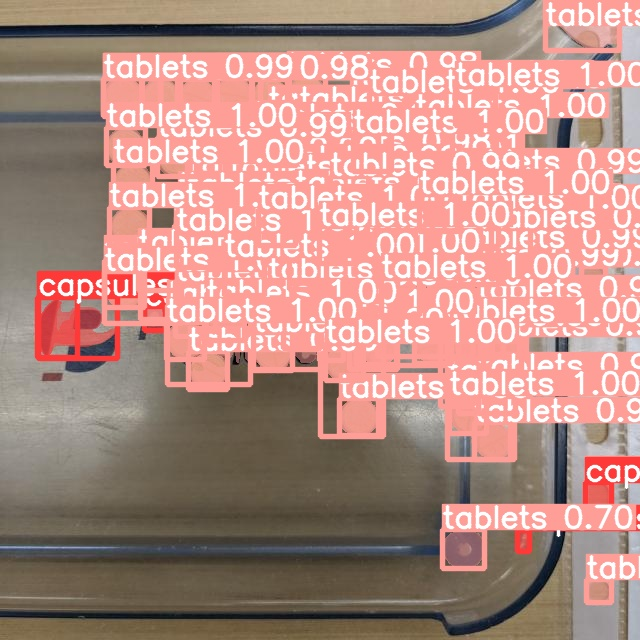

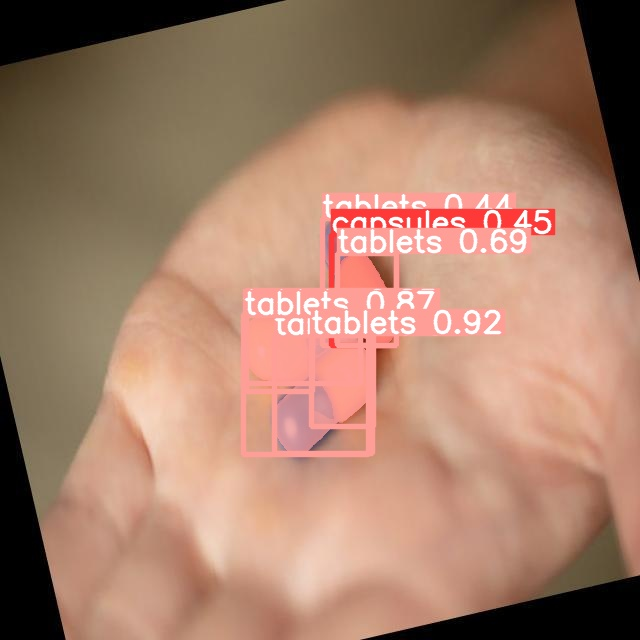

In [19]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict/*.jpg'):
      display(Image(filename=image_path, width=800))
      print("\n")